# (GSOC CALEL Test - 2024 proposal )

Loading the dataset from hugging face which was given

## Detailed analysis on the dataset.
(this is not the final work, just the approaches)

In [ ]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset('sakren/twitter_racism_dataset')
dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'id', 'Text', 'Annotation', 'oh_label'],
        num_rows: 13471
    })
})

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.DataFrame(dataset['train'])
df

,index,id,Text,Annotation,oh_label
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,5.766462e+17,5.766462e+17,"Finally I'm all caught up, and that sudden dea...",none,0
4,5.713492e+17,5.713492e+17,@carolinesinders @herecomesfran *hugs*,none,0
...,...,...,...,...,...
13466,5.755964e+17,5.755964e+17,#mkr NOOOOO!!! I wanted Kat and Andre to lose!!!,none,0
13467,5.580631e+17,5.580631e+17,RT @MumtazCeltik: @WhiteHouse @VP \n\n#Kobane ...,none,0
13468,5.755969e+17,5.755969e+17,Glad the proper competition is starting and ev...,none,0
13469,5.755990e+17,5.755990e+17,"No worries Pete and Manu, take all the time of...",none,0


In [ ]:
!pip install transformers


In the following you can see that the dataset is not balanced. it can be made balanced by adding extra minor data

In [ ]:
df['Annotation'].value_counts()

none      11501
racism     1970
Name: Annotation, dtype: int64

## Removing the columns which cannot add value to solve the task and colums whose data is redundant.

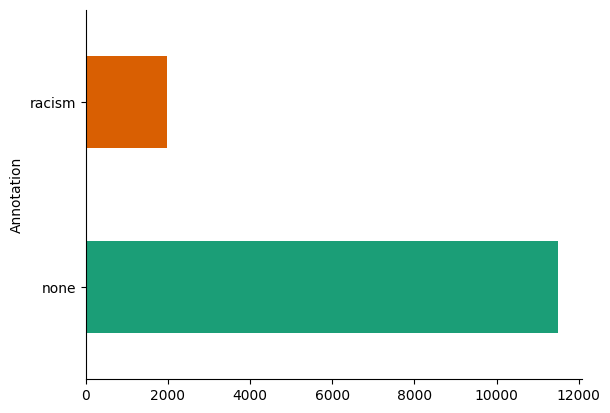

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Annotation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df = df.drop(['index' , 'id' , 'Annotation'] , axis = 1)
df.head(3)

,Text,oh_label
0,@AAlwuhaib1977 Muslim mob violence against Hin...,1
1,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,0
2,@jncatron @isra_jourisra @AMPalestine Islamoph...,1


## Preprocessing the text. A a good processing method and data-cleaning is very important because it can affect the learning of the process. Unnecessary noise can reduce the performance of the model.

Main processing steps that were done are -
- Removing the usernames. Removal of username is required to protect the privacy of the users and avoid threats or privacy preach problems.
- Removing the url links because they just add noise and hold not much context.
- And the basic special character removal and all that. In this experiment I have not removed stoppwords because some words like not , yes , no can provide some context.

In [ ]:

import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+\s?', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Text'] = df['Text'].apply(preprocess_text)

print(df)


                                                    Text  oh_label
0      muslim mob violence against hindus in banglade...         1
1                                                                0
2      islamophobia is like the idea of naziphobia is...         1
3      finally im all caught up and that sudden death...         0
4                                                   hugs         0
...                                                  ...       ...
13466          mkr nooooo i wanted kat and andre to lose         0
13467  rt kobane jesuischarlie turkish military says ...         0
13468  glad the proper competition is starting and ev...         0
13469  no worries pete and manu take all the time off...         0
13470  mkr please kick off that lady who is such a ru...         0

[13471 rows x 2 columns]


##Firstly I am starting the experiment using SVM classifier. For better explaination have implemented using tensorflow.
here I have used tfidf vectorizer. Term frequency inverse document frequency is a statistical a mesure to know the importance of the word in a document. more common the word is , less important it becomes.
so in this corpus of racism detection data , this method can give importance to the triggering words and svm classifier which is in layman terms can seperate different groups and here as ther are only two classs , it was chosen


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split

data = df
train_texts, test_texts, train_labels, test_labels = train_test_split(data['Text'].astype(str), data['oh_label'], test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000)
train_features = vectorizer.fit_transform(train_texts)
val_features = vectorizer.transform(val_texts)
test_features = vectorizer.transform(test_texts)

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features, train_labels)



SVC(kernel='linear')

In [ ]:

val_predictions = svm_classifier.predict(val_features)

val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

test_predictions = svm_classifier.predict(test_features)

test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.9276437847866419
Test Accuracy: 0.9276437847866419


After the above experiment and before going to pretrained models,
 # I have built a very simple bilstm architechture
 but the results seen are at par with the pre - trained models like bert as can be seen later. by care fully fine tuning it better results might be achieved which is the future work.
 BiLSTMs can automatically extract features from text data that are relevant for the classification task. This includes learning which words or phrases are indicative of racist sentiment.By processing the data in both directions, BiLSTMs can capture dependencies and relationships in the text that might be missed with a unidirectional approach.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape

vectorizer = TfidfVectorizer(max_features=10000)
train_features = vectorizer.fit_transform(train_texts)
val_features = vectorizer.transform(val_texts)
test_features = vectorizer.transform(test_texts)

train_features_dense = train_features.toarray()
val_features_dense = val_features.toarray()
test_features_dense = test_features.toarray()

input_layer = Input(shape=(train_features_dense.shape[1],))
reshape_layer = Reshape((train_features_dense.shape[1], 1))(input_layer)
lstm_layer = Bidirectional(LSTM(64))(reshape_layer)
output_layer = Dense(2, activation='softmax')(lstm_layer)
bi_model = Model(inputs=input_layer, outputs=output_layer)

bi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels_one_hot = to_categorical(train_labels, num_classes=2)
val_labels_one_hot = to_categorical(val_labels, num_classes=2)

train_dataset = tf.data.Dataset.from_tensor_slices((train_features_dense, train_labels_one_hot)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_features_dense, val_labels_one_hot)).batch(32)

bi_model.fit(train_dataset, epochs=5, validation_data=val_dataset)


Epoch 1/5
270/270 [==============================] - 165s 575ms/step - loss: 0.4297 - accuracy: 0.8545 - val_loss: 0.4178 - val_accuracy: 0.8534
Epoch 2/5
270/270 [==============================] - 146s 540ms/step - loss: 0.4169 - accuracy: 0.8545 - val_loss: 0.4178 - val_accuracy: 0.8534
Epoch 3/5
270/270 [==============================] - 146s 539ms/step - loss: 0.4163 - accuracy: 0.8545 - val_loss: 0.4180 - val_accuracy: 0.8534
Epoch 4/5
270/270 [==============================] - 145s 538ms/step - loss: 0.4160 - accuracy: 0.8545 - val_loss: 0.4181 - val_accuracy: 0.8534
Epoch 5/5
270/270 [==============================] - 144s 535ms/step - loss: 0.4158 - accuracy: 0.8545 - val_loss: 0.4181 - val_accuracy: 0.8534


In [ ]:
bi_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 reshape (Reshape)           (None, 10000, 1)          0         
                                                                 
 bidirectional (Bidirection  (None, 128)               33792     
 al)                                                             
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 34050 (133.01 KB)
Trainable params: 34050 (133.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_labels_one_hot = to_categorical(test_labels, num_classes=2)

test_dataset = tf.data.Dataset.from_tensor_slices((test_features_dense, test_labels_one_hot)).batch(32)

test_loss, test_accuracy = bi_model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


85/85 [==============================] - 24s 273ms/step - loss: 0.4217 - accuracy: 0.8516
Test Accuracy: 85.16%


Testing with Logistic regression -

In [ ]:
from sklearn.linear_model import LogisticRegression

regressor = LogisticRegression()
regressor.fit(train_features , train_labels)

LogisticRegression()

In [ ]:
val_reg_predictions = regressor.predict(val_features)
val_accuracy_reg = accuracy_score(val_labels, val_reg_predictions)
print("Validation Accuracy:", val_accuracy_reg)

test_predictions_reg = regressor.predict(test_features)

test_accuracy_reg = accuracy_score(test_labels, test_predictions_reg)
print("Test Accuracy:", test_accuracy_reg)

Validation Accuracy: 0.9049165120593692
Test Accuracy: 0.9165120593692022


## we can see that the tfidf with SVM gave better results on our data.

- Future work would be to use more powerful embeddings which contain more contextual information like bert embeddings and testing it with logistic regression

In [ ]:
!pip install tensorflow

#Now I am using the BERT uncased model.
 Bert uses transformer based architecture to to analyse words in relation to others also enchanced by its attention mechanism. it is trained on large data and has very good contextual understanding.
there are two varietes in which Bert comes in , case and uncased and as mentioned because as the dataset has only english language and accent of the language for example won't matter much so uncased would suffice. And I'm implementing the Bert base model , which has 12 encoder blocks, 12 self - attention heads and 110 million parameters.

This mechanism allows BERT to focus on the most relevant parts of the text, assigning more weight to certain words or phrases that are crucial for understanding the context and sentiment of the message. By doing so, BERT can identify subtle cues and patterns indicative of racist language, even when they are not overtly expressed.

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

texts = df['Text'].values
labels = df['oh_label'].values

print(texts)

['muslim mob violence against hindus in bangladesh continues in 2014 islam'
 ''
 'islamophobia is like the idea of naziphobia islam is a religion of hate and it must be outlawed'
 ...
 'glad the proper competition is starting and even happier that colin is back mkr'
 'no worries pete and manu take all the time off you need in fact feel free to fuck right off i prefer colin mkr'
 'mkr please kick off that lady who is such a rude person she has such a crappy attitude towards the others shes gave a one']


In [ ]:
data = df
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install tf-keras

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
data = df
data = data.dropna(subset=['Text'])

train_texts, test_texts, train_labels, test_labels = train_test_split(data['Text'].astype(str), data['oh_label'], test_size=0.2, random_state=42)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)


In [ ]:
len(val_texts)

2156

In [ ]:

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


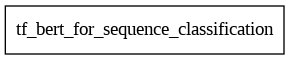

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:

metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer= 'adam',  loss=loss, metrics=[metric])

model.fit(train_dataset.shuffle(100).batch(32), epochs=3, batch_size=32, validation_data=val_dataset.batch(32))


Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
270/270 [==============================] - 234s 465ms/step - loss: 0.4442 - accuracy: 0.8445 - val_loss: 0.4266 - val_accuracy: 0.8513
Epoch 2/3
270/270 [==============================] - 103s 382ms/step - loss: 0.4274 - accuracy: 0.8532 - val_loss: 0.4222 - val_accuracy: 0.8529
Epoch 3/3
270/270 [==============================] - 104s 386ms/step - loss: 0.4271 - accuracy: 0.8534 - val_loss: 0.4218 - val_accuracy: 0.8532


 as the dataset is too small and imbalanced the model is highly likely to get overfit. this is taken care in the in the futre work schedule where more collction of data is done and with finetuning and other techniques to reduce overfitting. however the test accuracy is similar is all the three pretrained model used which is around 85% we can say that model is generalising well.

In [ ]:

test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

85/85 [==============================] - 14s 169ms/step - loss: 0.4251 - accuracy: 0.8528
Test Loss: 0.42507463693618774
Test Accuracy: 0.8527935147285461


In [ ]:

test_texts_list = []
true_labels_list = []
predicted_labels_list = []

for inputs, labels in test_dataset.batch(32):
    predictions = model.predict(inputs)
    logits = predictions.logits
    predicted_labels = np.argmax(tf.nn.softmax(logits, axis=-1), axis=1)
    for text, true_label, predicted_label in zip(inputs['input_ids'], labels, predicted_labels):
        test_texts_list.append(tokenizer.decode(text.numpy()))
        true_labels_list.append(true_label.numpy())
        predicted_labels_list.append(predicted_label)

ndf = pd.DataFrame({
    'Text': test_texts_list,
    'True Label': true_labels_list,
    'Predicted Label': predicted_labels_list
})


ndf


1/1 [==============================] - 9s 9s/step


,Text,True Label,Predicted Label
0,[CLS] swf looking for long walks on the beach ...,0,0
1,[CLS] # mkr so many tent and pole jokes tonigh...,0,0
2,[CLS] rt @ strictmachine : @ freebsdgirl did y...,0,0
3,[CLS] oh. the south africans weren't happy. bu...,0,0
4,[CLS] # mkr goodbye girls you will be missed [...,0,0
...,...,...,...
2690,"[CLS] this isn't going to work, because we've ...",0,0
2691,[CLS] @ peerworker you made a false equivalenc...,0,0
2692,[CLS] rt @ lynnemcgranger : # mkr devo @ emily...,0,0
2693,[CLS] @ youfoundthecard indeed. but i've been ...,0,0


# used Distilbert next
Tried with distilbert which is a smaller, faster and lighter version of Bert which has about 97% of the BERT's language understanding capabilites while being 60% faster.

In [ ]:

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

tokenizer_2 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer_2(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer_2(test_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer_2(val_texts.tolist(), truncation=True, padding=True , max_length = 128)



model_2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model_2.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_2.compile(optimizer='adam', loss=loss, metrics=[metric])


history_distilB = model_2.fit(train_dataset.shuffle(100).batch(32), epochs=3, batch_size=32, validation_data=val_dataset.batch(32))

Epoch 1/3
270/270 [==============================] - 108s 265ms/step - loss: 0.4289 - accuracy: 0.8435 - val_loss: 0.4260 - val_accuracy: 0.8515
Epoch 2/3
270/270 [==============================] - 60s 221ms/step - loss: 0.4219 - accuracy: 0.8533 - val_loss: 0.4432 - val_accuracy: 0.8530
Epoch 3/3
270/270 [==============================] - 60s 223ms/step - loss: 0.4225 - accuracy: 0.8538 - val_loss: 0.4202 - val_accuracy: 0.8534


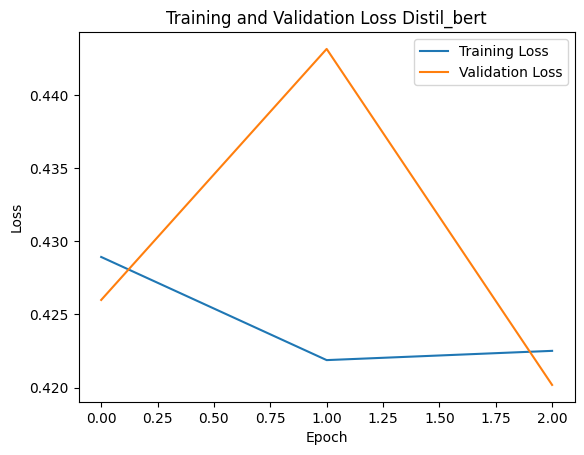

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_distilB.history['loss'], label='Training Loss')
plt.plot(history_distilB.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Distil_bert')
plt.legend()
plt.show()

overfitted

In [ ]:

test_loss, test_accuracy = model_2.evaluate(test_dataset.batch(32))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

85/85 [==============================] - 9s 53ms/step - loss: 0.4239 - accuracy: 0.8536
Test Loss: 0.4238959848880768
Test Accuracy: 0.8536332249641418


In [ ]:

test_texts_list = []
true_labels_list = []
predicted_labels_list = []

for inputs, labels in test_dataset.batch(32):
    predictions = model_2.predict(inputs)
    logits = predictions.logits
    predicted_labels = np.argmax(tf.nn.softmax(logits, axis=-1), axis=1)
    for text, true_label, predicted_label in zip(inputs['input_ids'], labels, predicted_labels):
        test_texts_list.append(tokenizer_2.decode(text.numpy()))
        true_labels_list.append(true_label.numpy())
        predicted_labels_list.append(predicted_label)

n3df = pd.DataFrame({
    'Text': test_texts_list,
    'True Label': true_labels_list,
    'Predicted Label': predicted_labels_list
})

n3df.head()



1/1 [==============================] - 4s 4s/step


,Text,True Label,Predicted Label
0,[CLS] swf looking for long walks on the beach ...,0,0
1,[CLS] mkr so many tent and pole jokes tonight ...,0,0
2,[CLS] rt did you check back in their timeline ...,0,0
3,[CLS] oh the south africans werent happy but t...,0,0
4,[CLS] mkr goodbye girls you will be missed [SE...,0,0


The results achieved are similar and very close to Bert.

# used Roberta
Robustly optimised Bert , builds upon Bert by modifying key parameters. here it removes the next-sentence pretraining objective and is trained with larger mini-batches and learning rates. RoBERTa uses dynamic masking, where the masked tokens are changed during each training epoch, unlike BERT, which uses static masking.

other specifications used are same in all the three implementation, using adam optimizer, and sparse-categorical-crossentropy loss , with an 80 - 20 split of train and test split.

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import tensorflow as tf

tokenizer_3 = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer_3(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer_3(test_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer_3(val_texts.tolist(), truncation=True, padding=True, max_length=128)

model_3 = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model_3.compile(optimizer='adam', loss=loss, metrics=[metric])


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
num_labels = model_3.config.num_labels

print("Number of classes considered by the model:", num_labels)

Number of classes considered by the model: 2


In [ ]:
model_3.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_3.fit(train_dataset.shuffle(100).batch(32), epochs=3, batch_size=32, validation_data=val_dataset.batch(32))

Epoch 1/3
270/270 [==============================] - 120s 445ms/step - loss: 0.4206 - accuracy: 0.8525 - val_loss: 0.4183 - val_accuracy: 0.8524
Epoch 2/3
270/270 [==============================] - 103s 380ms/step - loss: 0.4208 - accuracy: 0.8538 - val_loss: 0.4221 - val_accuracy: 0.8533
Epoch 3/3
270/270 [==============================] - 102s 378ms/step - loss: 0.4198 - accuracy: 0.8540 - val_loss: 0.4215 - val_accuracy: 0.8537


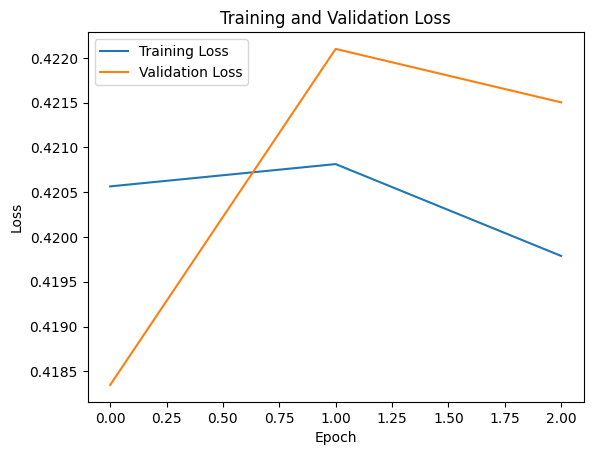

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

overfitted

In [ ]:

test_loss, test_accuracy = model_3.evaluate(test_dataset.batch(32))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

85/85 [==============================] - 19s 93ms/step - loss: 0.4253 - accuracy: 0.8538
Test Loss: 0.42530348896980286
Test Accuracy: 0.8538283109664917


In [ ]:
df['Text'][110]


'shame the razor blades werent near your throat mkr'

In [ ]:
df['oh_label'][110]

0

In [ ]:
df

,index,id,Text,Annotation,oh_label
0,5.767493e+17,5.767493e+17,muslim mob violence against hindus in banglade...,racism,1
1,5.408905e+17,5.408905e+17,,none,0
2,5.678433e+17,5.678433e+17,islamophobia is like the idea of naziphobia is...,racism,1
3,5.766462e+17,5.766462e+17,finally im all caught up and that sudden death...,none,0
4,5.713492e+17,5.713492e+17,hugs,none,0
...,...,...,...,...,...
13466,5.755964e+17,5.755964e+17,mkr nooooo i wanted kat and andre to lose,none,0
13467,5.580631e+17,5.580631e+17,rt kobane jesuischarlie turkish military says ...,none,0
13468,5.755969e+17,5.755969e+17,glad the proper competition is starting and ev...,none,0
13469,5.755990e+17,5.755990e+17,no worries pete and manu take all the time off...,none,0


In [ ]:

test_texts_list = []
true_labels_list = []
predicted_labels_list = []

for inputs, labels in test_dataset.batch(32):
    predictions = model_3.predict(inputs)
    logits = predictions.logits
    predicted_labels = np.argmax(tf.nn.softmax(logits, axis=-1), axis=1)
    for text, true_label, predicted_label in zip(inputs['input_ids'], labels, predicted_labels):
        test_texts_list.append(tokenizer_3.decode(text.numpy()))
        true_labels_list.append(true_label.numpy())
        predicted_labels_list.append(predicted_label)

n2df = pd.DataFrame({
    'Text': test_texts_list,
    'True Label': true_labels_list,
    'Predicted Label': predicted_labels_list
})





1/1 [==============================] - 11s 11s/step


In [ ]:
n2df

,Text,True Label,Predicted Label
0,likemajor05 separate Santa21 gather identifie...,0,0
1,like hailed sex focused cross reviewing fifth...,0,0
2,like floated tour progress disclosed waitha c...,0,0
3,like grand asking capacitylocal racesadoque c...,0,0
4,like hailed sexcol goods progress prevent35Ch...,0,0
...,...,...,...
2690,like� headedado selling Nigeria climate broth...,0,0
2691,like progress exchange football leverage pare...,0,0
2692,like floated hailed sexelson assault grand ap...,0,0
2693,like tiny committed engagement Fox OhioUnfort...,0,0


Inference

In [ ]:

tokenizer_3 = RobertaTokenizer.from_pretrained('roberta-base')

random_sentence = "shame the razor blades werent near your throat "
inputs = tokenizer_3(random_sentence, return_tensors="tf", padding=True, truncation=True, max_length=128)

outputs = model_3(inputs)

predicted_probabilities = tf.nn.softmax(outputs.logits, axis=-1)
predicted_label_index = tf.argmax(predicted_probabilities, axis=1).numpy()[0]

print("Predicted Class Label Index:", predicted_label_index)

classes = { 0 : 'none' , 1 : 'racism'}
predicted_label = classes[predicted_label_index]

print("Predicted Class Label:", predicted_label)


Predicted Class Label Index: 0
Predicted Class Label: none
